## 1 优化器

神经网络是基于连接的人工智能，当网络结构固定后，不同参数选取对模型的表达力影响很大。更新模型参数的过程，就仿佛是在教一个孩子理解世界的过程，达到学龄的孩子，脑神经元的结构、规模是相似的，都具备了学习的潜力，但是不同的引导方法，会让孩子具备不同的能力，达到不同的高度。优化器就是引导神经网络更新参数的工具。

接下来主要分享一下五种常用的神经网络参数优化器：
 + SGD
 + SGDM
 + AdaGrad
 + RMSProp
 + Adam

以上也属于一阶优化算法，一阶优化就是指的梯度算法及其变种。（二阶优化一般是用二阶导数（Hessian 矩阵）来计算，计算复杂且计算量较大）。

下面对一阶优化算法的定以做出说明：

> 定义：待优化参数 $w$，损失函数 $f(w)$，初始学习率 $\alpha$，每次迭代一个 batch，$t$ 表示当前 batch 迭代的总次数。更新参数分四步完成：
> 1. 计算 $t$ 时刻损失函数关于当前参数的梯度 $g_t = \triangledown f(w_t)=\frac{\partial f} {\partial w_t}$
> 2. 计算 $t$ 时刻一阶动量 $m_t = \phi (g_1, g_2, ... ,g_t)$ 和二阶动量 $V_t = \psi  (g_1, g_2, ... ,g_t)$
>  + 一阶动量：与梯度相关的函数
>  + 二阶动量：与梯度平方相关的函数
> 3. 计算 $t$ 时刻下降梯度：$\eta_t=lr \cdot \frac {m_t}{\sqrt{V_t}}$
> 4. 计算 $t+1$ 时刻参数：$\omega_{t+1} = \omega_{t}-\eta_t = \omega_t - lr \cdot \frac{m_t}{\sqrt{V_t}}$

**步骤 3 和 4 对于各算法都是一致的，主要差别体现在步骤 1 和 2 上，不同的优化器实质上只是定义了不同的一阶动量和二阶动量公式。**

### 1.1 SGD

随机梯度下降法（stochastic gradient descent），简称 SGD。是最常用也是最简单的梯度下降法。根据之前描述的定义，指出 SGD 各值的表示形式：
 + 一阶动量 $m_t=g_t$，即 SGD 的一阶动量就是梯度
 + 二阶动量 $V_t=1$，即二阶动量恒等于 1
 + $t$ 时刻下降梯度 $\eta_t=lr \cdot \frac {m_t}{\sqrt{V_t}} = lr \cdot g_t$
 + $t+1$ 时刻参数 $\omega_{t+1} = \omega_{t}-\eta_t = \omega_t - lr \cdot \frac{m_t}{\sqrt{V_t}}=\omega_t-lr \cdot g_t$

这也就是之前一直在使用的参数更新公式。而最初版本的 SGD 是没有动量的概念的，这里只是为了与之后要讲解的优化算法进行统一。

代码实现：
```python
w1.assign_sub(lr * grads[0])
b1.assign_sub(lr * grads[1])
```
TensorFlow API:  
 + `tf.keras.optimizers.SGD`

SGD 也存在缺点：如果函数的形状非均向（anisotropic），比如呈延伸状，搜索的路径就会非常低效，且可能会在沟壑的两边持续震荡，停留在一个局部最优点，下降速度慢。为了说明这一问题，下面定义一个函数，并绘制出 SGD 在该函数中的搜索过程

$$f(x,y)=\frac{1}{20}x^2+y^2$$

先看一下函数的形状

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 定义函数
f = lambda x, y: x**2 / 20.0 + y**2

In [3]:
# 定义导函数
df = lambda x, y: [x / 10.0, 2.0 * y]

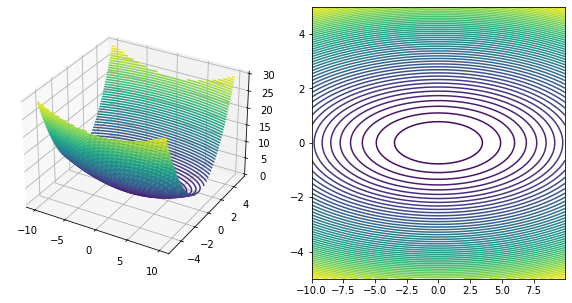

In [4]:
x = np.arange(-10, 10, 0.01)
y = np.arange(-5, 5, 0.01)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.contour3D(X, Y, Z, 50)
ax2 = fig.add_subplot(122)
ax2.contour(X, Y, Z, 50)
plt.show()

可以发现这个函数的图形就是呈延伸状。为了观察 SGD 在该函数上的搜索过程，我们还需要写一些代码，并且之后介绍的几个优化器算法都会在这一函数中进行搜索，以此来观察不同优化器算法的区别。

实现 fit_and_plot 函数
 + init_x, init_y 为初始坐标点，定义为 (-7.0, 2.0)
 + lr 为学习率，默认0.01，偏小则需要根据实际情况修改
 + epoch 为梯度下降的迭代次数，默认 30 次
 + f, df 分别为函数，和导函数
 + optimizer 为优化器，需根据情况传入具体函数

In [5]:
def plot_trace(init_x=-7.0, init_y=2.0, epoch=30, optimizer=None):
    # 需要更新的参数
    params = {
        'x': tf.Variable(init_x, dtype=tf.float32),
        'y': tf.Variable(init_y, dtype=tf.float32)
    }
    grads = {'x':0, 'y': 0}
    # 记录每次搜索的坐标
    x_history, y_history = [], []
    for i in range(epoch):
        # 记录坐标
        x_history.append(params['x'].numpy())
        y_history.append(params['y'].numpy())
        # 计算梯度
        grads['x'] ,grads['y'] = df(params['x'], params['y'])
        if optimizer:
            optimizer(params, grads)
    # 初始化图象数据
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    # 绘制图像
    plt.plot(x_history, y_history, 'o-', color='red')
    plt.contour(X, Y, Z)
    plt.plot(0, 0, '+')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

SGD 优化器算法实现如下：
 + params 为需要更新的参数字典，参数更新方式都是统一的，因此可以用循环来简化代码量
 + grads 为每个参数在某一时刻的梯度，同样也是字典，并与 params 中的 key 值相对应
 + lr 为学习率

In [6]:
# 实现 SGD 优化器算法
def sgd(lr=0.01):
    def opt(params, grads):
        for key in params.keys():
            params[key].assign_sub(lr * grads[key])
    return opt

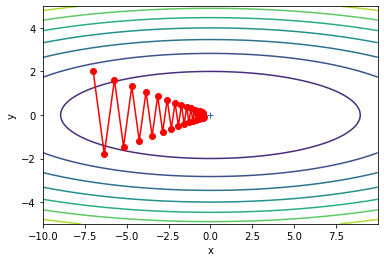

In [7]:
plot_trace(optimizer=sgd(lr=0.95))

可以发现 SGD 在该函数上呈“之”字形来回震荡，这是一个相当低效的路径

### 1.2 SGDM

SGDM 就是包含了动量（momentum）的 SGD，在上一节描述 SGD 的时曾表明初始的 SGD 是不包含动量的概念的。因此在 SGD 的基础上增加一阶动量就形成了 SGDM。

动量是一种有助于在梯度更新方向上加速并抑制振荡的一种梯度下降方法。对于梯度指向的方向，动量会增加，并且会减少对非梯度方向的更新。可以认为是在梯度下降过程加入了惯性。形象点说，比如下坡的时候，如果发现是陡坡，就可以利用惯性跑的快一些。

 + 一阶动量 $m_t=\beta \cdot m_{t-1} + (1-\beta)\cdot g_t$ ：$m_{t-1}$ 表示上一时刻的一阶动量且 $\beta$ 是一个接近于 1 的超参数
 + 二阶动量 $V_t=1$
 + $t$ 时刻下降梯度 $\eta_t=lr \cdot \frac {m_t}{\sqrt{V_t}} = lr \cdot m_t=lr \cdot (\beta \cdot m_{t-1} + (1-\beta)\cdot g_t)$
 + $t+1$ 时刻参数 $\omega_{t+1} = \omega_{t}-\eta_t = \omega_t - lr \cdot \frac{m_t}{\sqrt{V_t}}=\omega_t-lr \cdot (\beta \cdot m_{t-1} + (1-\beta)\cdot g_t)$

一阶动量是各个时刻梯度方向的指数移动平均值，约等于最近 $1 / (1 - \beta_t)$ 个时刻的梯度向量和的平均值。也就是说，t 时刻的下降方向，不仅由当前点的梯度方向决定，而且由此前累积的下降方向决定。$beta$ 的经验值为0.9，这就意味着下降方向主要偏向此前累积的下降方向，并略微偏向当前时刻的下降方向。

Ttf.keras.optimizers.SGD

代码实现：
```python
beta = 0.9
m_w, m_b = 0, 0
m_w = beta * m_w + (1 - beta) * grads[0]
m_b = beta * m_b + (1 - beta) * grads[1]
w1.assign_sub(lr * m_w)
b1.assign_sub(lr * m_b)
```

TensorFlow API:
 + `tf.keras.optimizers.SGD` 如果不指定参数 `momentum` 就是 SGD，若修改了该值就是 SGDM

上面的代码是对 SGDM 思想的一般翻译，但其实对于要更新的参数，更新方式都是一样的，因此可以使用循环的方式来简化代码

In [8]:
def sgdm(lr=0.1, beta=0.9):
    momentum = {}
    def opt(params, grads):
        # 为每个参数定义动量，只初始化一次
        if len(momentum) == 0:
            for key, val in params.items():
                momentum[key] = tf.zeros_like(val)

        for key in params.keys():
            # 更新动量
            momentum[key] = beta * momentum[key] + lr * grads[key]
            # 更新参数
            params[key].assign_sub(momentum[key])
    return opt

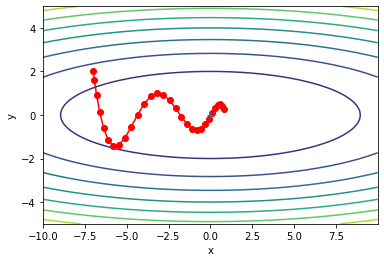

In [9]:
plot_trace(optimizer=sgdm(lr=0.1))

相比于 SGD，很明显 SGDM 的震荡幅度变小了

### 1.3 AdaGrad

SGD对所有的参数使用统一的、固定的学习率，一个自然的想法是对每个参数设置不同的学习率，然而在大型网络中这是不切实际的。因此，为解决此问题 AdaGrad 算法被提出，其做法是给学习率一个缩放比例，从而达到了自适应学习率的效果（Ada = Adaptive）。其思想是：对于频繁更新的参数，不希望被单个样本影响太大，因此使用很小的学习率；对于偶尔出现的参数，希望能多得到一些信息，因此使用较大的学习率。

那怎么样度量历史更新频率呢？为此引入二阶动量——该维度上，所有梯度值的平方和：

$$V_t=\sum_{i=1}^t g_i^2$$

 + 一阶动量 $g_t$
 + 二阶动量 $V_t=\sum_{i=1}^t g_i^2$
 + $t$ 时刻下降梯度 $\eta_t = lr \cdot \frac{m_t} {\sqrt V_t} = lr \cdot \frac{m_t} {\sqrt{\sum_{i=1}^t g_i^2}}$
 + $t+1$ 时刻参数 $\omega_{t+1} = \omega_{t}-\eta_t = \omega_t - lr \cdot \frac{m_t}{\sqrt{V_t}}=\omega_t-lr \cdot \frac{g_t} {\sqrt{\sum_{i=1}^t g_i^2}}$


回顾步骤 3 中的下降梯度：$\eta_t = \alpha \cdot \frac{m_t} {\sqrt V_t}$ 可视为 $\eta_t = \frac{\alpha} {\sqrt V_t} \cdot m_t$，即对学习率进行缩放。（一般为了防止分母为 0 ，会对二阶动量加一个平滑项，即 $\varepsilon$，是一个非常小的数。）

AdaGrad 在稀疏数据场景下表现最好。因为对于频繁出现的参数，学习率衰减得快；对于稀疏的参数，学习率衰减得更慢。然而在实际很多情况下，二阶动量呈单调递增，累计从训练开始的梯度，学习率会很快减至 0 ，导致参数不再更新，训练过程提前结束。

代码实现：
```python
v_w, v_b = 0, 0
v_w += tf.square(grads[0])
v_b += tf.square(grads[1])
w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))
```

TensorFlow API:  
 + `tf.keras.optimizers.Adagrad`

In [10]:
def adagrad(lr=0.01):
    v = {}
    def opt(params, grads):
        if len(v) == 0:
            for key, val in params.items():
                v[key] = tf.zeros_like(val)
        for key in params.keys():
            v[key] += tf.square(grads[key])
            params[key].assign_sub(lr * grads[key] / tf.sqrt(v[key]))
    return opt

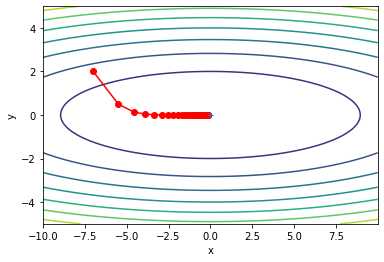

In [11]:
plot_trace(optimizer=adagrad(lr=1.5))

### 1.4 RMSProp

RMSProp（Root Mean Square Prop）是在 SGD 的基础上增加了二阶动量，由于 AdaGrad 的学习率衰减太过激进，因此考虑改变二阶动量的计算策略：不累计全部梯度，只关注过去某一窗口内的梯度,即二阶动量 $V_t$ 使用指数滑动平均值计算，表征的是过去一段时间的平均值，反映“局部的”参数信息。
 + 一阶动量 $m_t=g_t$
 + 二阶动量 $V_t=\beta \cdot V_{t-1}+(1-\beta) \cdot g_t^2$
 + $t$ 时刻下降梯度 $\eta_t=lr \cdot \frac {m_t}{\sqrt{V_t}} = lr \cdot \frac{g_t} {\sqrt{\beta \cdot V_{t-1} + (1-\beta)\cdot g_t^2}}$
 + $t+1$ 时刻参数 $\omega_{t+1} = \omega_{t}-\eta_t = \omega_t - lr \cdot \frac{g_t} {\sqrt{\beta \cdot V_{t-1} + (1-\beta)\cdot g_t^2}}$

代码实现：
```python
v_w, v_b = 0, 0
beta = 0.9

v_w = beta * v_w + (1 - beta) * tf.square(grads[0])
v_b = beta * v_b + (1 - beta) * tf.square(grads[1])
w1.assign_sub(lr * grads[0] / tf.sqrt(v_w))
b1.assign_sub(lr * grads[1] / tf.sqrt(v_b))
```

TensorFlow API: 
 + `tf.keras.optimizers.RMSprop`

In [12]:
def rmsprop(lr=0.01, beta=0.99):
    v = {}
    def opt(params, grads):
        if len(v) == 0:
            for key, val in params.items():
                v[key] = tf.zeros_like(val)
        for key in params.keys():
            v[key] = beta * v[key] + (1 - beta) * tf.square(grads[key])
            params[key].assign_sub(lr * grads[key] / tf.sqrt(v[key]))
    return opt

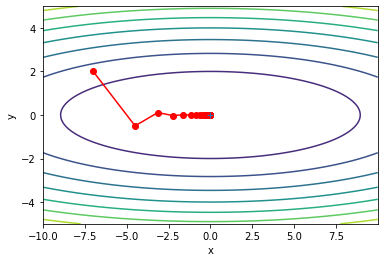

In [13]:
plot_trace(optimizer=rmsprop(lr=0.25))

### 1.5 Adam

Adam 同时结合了 SGDM 一阶动量和 RMSProp 二阶动量，并在此基础上增加了两个修正项，把修正后的一阶动量和二阶动量，是前述方法的集大成者。

 + SGDM 的一阶动量 $m_t=\beta_1 \cdot m_{t-1}+(1-\beta_1) \cdot g_t$
  + 修正一阶动量的偏差$\widehat{m_t} = \frac {m_t}{1-\beta_1^t}$
 + RMSProp 的二阶动量 $V_t=\beta_2 \cdot V_{step-1}+(1-\beta_2) \cdot g_t^2$
  + 修正二阶动量的偏差 $\widehat{V_t}=\frac{V_t}{1-\beta_2^t}$
 + $t$ 时刻下降梯度 $\eta_t = lr \cdot \frac{\widehat{m_t}}{\sqrt{\widehat{V_t}}}=lr \cdot \frac{m_t}{1-\beta_1^t}/\sqrt{\frac{V_t}{1-\beta_2^t}}$
 + $t+1$ 时刻参数 $\omega_{t+1} = \omega_t - \eta_t=\omega_t - lr \cdot \frac{m_t}{1-\beta_1^t}/\sqrt{\frac{V_t}{1-\beta_2^t}}$
 
其中，参数经验值是 $\beta_1=0.9, \beta_2=0.999$
 
代码实现：
```python
m_w, m_b = 0, 0
v_w, v_b = 0, 0
beta1, beta2 = 0.9, 0.999
delta_w, delta_b = 0, 0
global_step = 0

m_w = beta1 * m_w + (1 - beta1) * grads[0]
m_b = beta1 * m_b + (1 - beta1) * grads[1]
v_w = beta2 * v_w + (1 - beta2) * tf.square(grads[0])
v_b = beta2 * v_b + (1 - beta2) * tf.square(grads[1])

m_w_correction = m_w / (1 - tf.pow(beta1, int(global_step)))
m_b_correction = m_b / (1 - tf.pow(beta1, int(global_step)))
v_w_correction = v_w / (1 - tf.pow(beta2, int(global_step)))
v_b_correction = v_b / (1 - tf.pow(beta2, int(global_step)))

w1.assign_sub(lr * m_w_correction / tf.sqrt(v_w_correction))
b1.assign_sub(lr * m_b_correction / tf.sqrt(v_b_correction))
```

TensorFlow API:
 + `tf.keras.optimizers.Adam`

In [14]:
def adam(lr=0.01, beta1=0.9, beta2=0.999):
    global_step = 0
    m, v = {}, {}
    def opt(params, grads):
        nonlocal global_step 
        if len(m) == 0:
            for key, val in params.items():
                m[key] = tf.zeros_like(val)
                v[key] = tf.zeros_like(val)
        
        global_step += 1
        
        m_correction, v_correction = {}, {}
        for key in params.keys():
            m[key] = beta1 * m[key] + (1 - beta1) * grads[key]
            v[key] = beta2 * v[key] + (1 - beta2) * tf.square(grads[key])
            
            m_correction[key] = m[key] / (1 - tf.pow(beta1, int(global_step)))
            v_correction[key] = v[key] / (1 - tf.pow(beta2, int(global_step)))
            
            params[key].assign_sub(lr * m_correction[key] / tf.sqrt(v_correction[key]))
    return opt

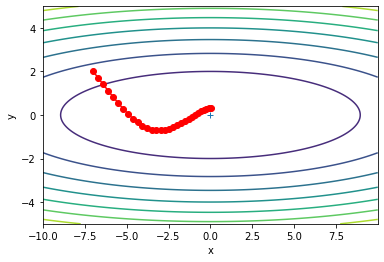

In [15]:
plot_trace(optimizer=adam(lr=0.3))